In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch import Tensor, nn
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as L
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from care_unet import CARE_UNet

### Important details 
1. Data is prepared with csbdeep create_patches, which uses percentile normalization. Because of that, this code does not involve careamics data processing in any capacity, as it is impossible to match the exact same data processing. 
2. The most important part of reproducibility is the unet architecture, learning rate and number of training steps. Here I'm leaving the number of training steps to default dataset length, and matching it in the csbdeep training. 
3. I'm not sure if optimizer and scheduler default parameter exact matching is as important for reproducibility, but did not test thoroughly. 
4. Csbdeep is loading "best" model from checkpoint by default, this is important for prediction. 
5. The network implementation is very naive, it does not support most of the argument customization from csbdeep - only repeats what is done if the parameters are left as default. Both 2D and 3D are implemented. 

In [2]:
seed_everything(42, workers=True)

Seed set to 42


42

### Create a lightning module for custom unet

In [3]:
class UnetModule(L.LightningModule):
    def __init__(self, n_depth=2, n_dim=2):
        super().__init__()
        self.model = CARE_UNet(
            n_depth=n_depth,
            n_dim=n_dim,
            residual=True,
            use_batchnorm=False,
        )
        self.loss = nn.L1Loss()
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=0.0004, betas=(0.9, 0.999), eps=1e-7
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=0.5,
            patience=10,
            threshold=0,
            threshold_mode="abs",
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = self.loss(y_pred, y)
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = self.loss(y_pred, y)
        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "lr",
            self.optimizer.param_groups[0]["lr"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def predict_step(self, batch: Tensor, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        return y_pred, x, y

    def configure_optimizers(self):
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": self.scheduler,
            "monitor": "val_loss",
        }

### Custom TB logger to match csbdeep logging

In [4]:
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities import rank_zero_only


class TBLogger(Logger):
    def __init__(self, log_path: Path):
        super().__init__()
        self.log_path = log_path
        self.logger_train = SummaryWriter(str(log_path / "logs/train"))
        self.logger_val = SummaryWriter(str(log_path / "logs/validation"))

    @property
    def name(self):
        return "TBLogger"

    @property
    def version(self):
        return "1.0"

    @rank_zero_only
    def log_hyperparams(self, params):
        if not isinstance(params, dict):
            params = vars(params)

        for logger in [self.logger_train, self.logger_val]:
            logger.add_hparams(
                hparam_dict=params,
                metric_dict={},
            )

    @rank_zero_only
    def log_metrics(self, metrics, step=None):
        if "train_loss" in metrics:
            self.logger_train.add_scalar(
                "epoch_loss", metrics["train_loss"], metrics["epoch"]
            )
        if "val_loss" in metrics:
            self.logger_val.add_scalar(
                "epoch_loss", metrics["val_loss"], metrics["epoch"]
            )
        if "lr" in metrics:
            self.logger_train.add_scalar("epoch_lr", metrics["lr"], metrics["epoch"])

    @rank_zero_only
    def finalize(self, status):
        self.logger_train.close()
        self.logger_val.close()

### Load data from csbdeep npz file

In [5]:
train_data = np.load("/group/jug/Vera/data/dexm/train/train_data_dexm.npz")
X_train, Y_train, axes = train_data["X"], train_data["Y"], train_data["axes"]

val_data = np.load("/group/jug/Vera/data/dexm/val/val_data_dexm.npz")
X_val, Y_val, axes = val_data["X"], val_data["Y"], val_data["axes"]

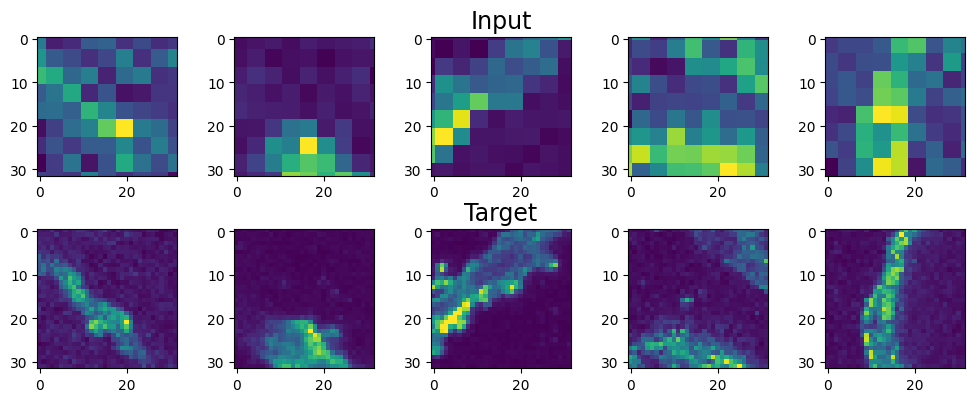

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.tight_layout()
ax[0, 2].set_title("Input", fontsize=17)
ax[1, 2].set_title("Target", fontsize=17)

for i in range(5):
    ax[0, i].imshow(X_train[i, 0, :, :].max(0), cmap="viridis")
    ax[1, i].imshow(Y_train[i, 0, :, :].max(0), cmap="viridis")
plt.show()

### Custom dataset with percentile normalization

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader


class CAREDataset(Dataset):
    def __init__(
        self,
        input_data: np.ndarray,
        target_data: np.ndarray = None,
        normalize: bool = False,
    ):
        self.input_data = input_data
        self.target_data = target_data
        self.normalize = normalize

        if self.normalize:
            self.mi = np.percentile(self.input_data, 2).astype(np.float32)
            self.ma = np.percentile(self.input_data, 99.8).astype(np.float32)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, index):
        input = self.input_data[index].astype(np.float32)
        input = torch.tensor(input)

        if self.normalize:
            input = (input - self.mi) / (self.ma - self.mi + 1e-20)
            return input
        else:
            target = self.target_data[index].astype(np.float32)
            target = torch.tensor(target)
            return input, target


class CAREDataModule(L.LightningDataModule):
    def __init__(self, train_data, train_target_data, val_data, val_target_data):
        super().__init__()
        self.train_data = train_data
        self.train_target_data = train_target_data
        self.val_data = val_data
        self.val_target_data = val_target_data

    def train_dataloader(self):
        dataset = CAREDataset(
            self.train_data, self.train_target_data, normalize=False
        )  # Here data comes from csbdeep create_patches, so it is already normalized!
        return DataLoader(dataset, batch_size=16, num_workers=4, shuffle=True)

    def val_dataloader(self):
        dataset = CAREDataset(self.val_data, self.val_target_data, normalize=False)
        return DataLoader(dataset, batch_size=16, num_workers=4, shuffle=False)

In [8]:
model = UnetModule(n_depth=2, n_dim=3)
print(sum(param.numel() for param in model.model.parameters()))

train_data_module = CAREDataModule(X_train, Y_train, X_val, Y_val)

# Create Callbacks
root = Path("experiments")
callbacks = [
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="care_lightning_api",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
]

# Create a Lightning Trainer
trainer = Trainer(
    max_epochs=100,
    default_root_dir=root,
    callbacks=callbacks,
    logger=TBLogger(log_path=root / "care_lightning_api"),
)

# Train the model
trainer.fit(model, datamodule=train_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


996769


/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /localscratch/dev/pipeline repository/exploratory_notebooks/experiments/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | CARE_UNet | 996 K  | train
1 | loss  | L1Loss    | 0      | train
--------------------------------------------
996 K     Trainable params
0         Non-trainable params
996 K     Total params
3.987     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Count metrics on validation set

In [9]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

# load the best model
print("Loading from ", root / "checkpoints/care_lightning_api.ckpt")
state = torch.load(root / "checkpoints/care_lightning_api.ckpt")
model = UnetModule(n_dim=3)
model.load_state_dict(state["state_dict"])

# Create a Lightning Trainer
results = trainer.predict(model, dataloaders=train_data_module.val_dataloader())

predictions = []
inputs = []
targets = []

for pred, x, y in results:
    predictions.extend(pred.squeeze(1))
    inputs.extend(x.squeeze(1))
    targets.extend(y.squeeze(1))

predictions = np.array(predictions)
inputs = np.array(inputs)
targets = np.array(targets)


ssim = []
psnr = []

for p, i, t in zip(predictions, inputs, targets):
    ssim.append(structural_similarity(t, p, data_range=t.max() - t.min()))
    psnr.append(peak_signal_noise_ratio(t, p, data_range=t.max() - t.min()))

print(np.mean(ssim), np.mean(psnr))

/tmp/ipykernel_44724/1616487711.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(root / "checkpoints/care_lightning_api.ckpt")
LOCAL_RANK: 0 - CUDA_VIS

Loading from  experiments/checkpoints/care_lightning_api.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

0.5748377621472618 23.423306439099544
